# Starbucks Capstone Challenge

* The program used to create the data simulates how people make purchasing decisions and how those decisions are influenced by promotional offers.

* Each person in the simulation has some hidden traits that influence their purchasing patterns and are associated with their observable traits. People produce various events, including receiving offers, opening offers, and making purchases.

* As a simplification, there are no explicit products to track. Only the amounts of each transaction or offer are recorded.

* There are three types of offers that can be sent: buy-one-get-one (BOGO), discount, and informational. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend. Offers can be delivered via multiple channels.

* <b>The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer.</b>


### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

<b>Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.</b> This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [2]:
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
portfolio.sort_values(by = ['offer_type', 'difficulty', 'duration'], ascending = [True, False, False])

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837


As we can see, there are three offer types - BOGO, discount and informational. <br><br>
For example, BOGO offer in the first row has difficulty of 10, meaning \\$10 is a minimum required amount that needs to be spent during 7 days (duration column). If that happens, a user gets a reward of \\$10 (reward column). User is informed about that offer through email, mobile and social channels (channels column). There is also offer id available (id_column). <br>
So, regarding BOGO, there are four offers in total; two where users need to spend \\$10 during 7 or 5 days, and if they do they get \\$10, and two where users need to spend \\$5 during 7 or 5 days and if they do, they get \\$5. <br><br>
There are four discount offers as well. In the first one, users need to spend \\$20 during 10 days, which would give them \\$5 discount if they do. In the next two offers, users need to spend \\$10 during 10 or 7 days, and if they do, they get \\$2 discount. Last discount offer requires that users spend \\$7 during 7 days, which qualifies them for \\$3 discount.<br><br>
Finally, informational offers don't have minimum purchase amount, and also don't give out any reward. As the name says, those offers are just providing information to the users; first one lasts 4 days and second one 3 days.

In [5]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


There are some missing values in gender and income columns, and it looks like those values might be missing for the same users.

In [7]:
profile[profile.applymap(lambda x: x is None)['gender']].income.unique()

array([nan])

In [8]:
len(profile[profile.applymap(lambda x: x is None)['gender']].income)

2175

Yes, for all columns where gender is None, income is missing as well.

In [9]:
round(profile['gender'].isnull().sum() / profile.shape[0], 2)

0.13

13% of userbase does not have gender and income data.

Column "became_member_on" is of type integer, however it should be date.

In [10]:
profile['became_member_on_date'] = pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')

In [11]:
profile.dtypes

gender                           object
age                               int64
id                               object
became_member_on                  int64
income                          float64
became_member_on_date    datetime64[ns]
dtype: object

We added new column, "became_member_on_date", which contains values from "became_member_on" formatted as dates.

In [12]:
min_date = profile['became_member_on_date'].min()
max_date = profile['became_member_on_date'].max()
print(min_date)
print(max_date)

2013-07-29 00:00:00
2018-07-26 00:00:00


In [13]:
# this function is originally from matplotlib website 
# https://matplotlib.org/stable/tutorials/introductory/lifecycle.html#sphx-glr-tutorials-introductory-lifecycle-py
# it is used to format income $ amounts for the third chart


def currency(x, pos):
    """The two arguments are the value and tick position"""
    if x >= 1e6:
        s = '${:1.1f}M'.format(x*1e-6)
    else:
        s = '${:1.0f}K'.format(x*1e-3)
    return s

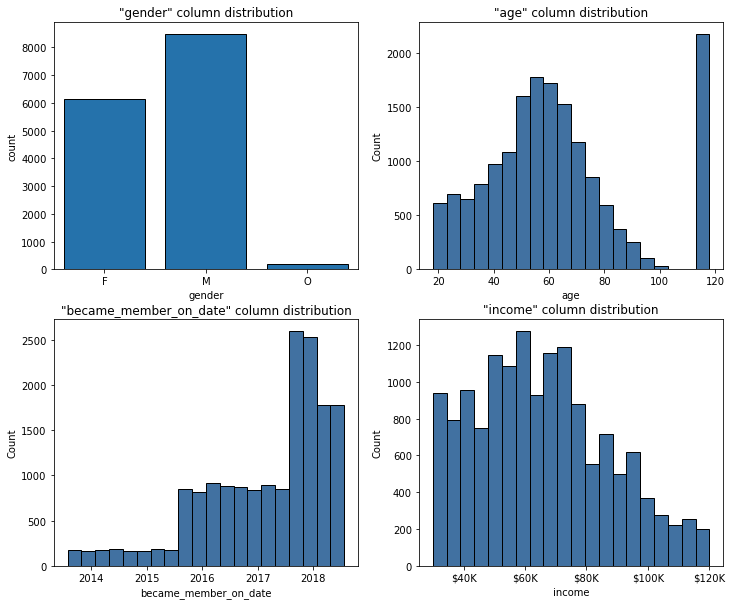

In [14]:
fig, axs = plt.subplots(2, 2, figsize = [12, 10]);

colors = ["#0F76C1"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

sns.countplot(x = 'gender', data = profile, color = '#0F76C1', edgecolor = "black", ax = axs[0, 0]);
axs[0, 0].set_title('"gender" column distribution')

sns.histplot(data=profile, x='age', bins = 20, ax = axs[0, 1], color = 'xkcd:darkish blue');
axs[0, 1].set_title('"age" column distribution');

sns.histplot(data=profile, x='became_member_on_date', bins = 20, ax = axs[1, 0], color = 'xkcd:darkish blue');
axs[1, 0].set_title('"became_member_on_date" column distribution');

sns.histplot(data=profile, x='income', bins = 20, ax = axs[1, 1], color = 'xkcd:darkish blue');
axs[1, 1].set_title('"income" column distribution');
axs[1, 1].xaxis.set_major_formatter(currency)

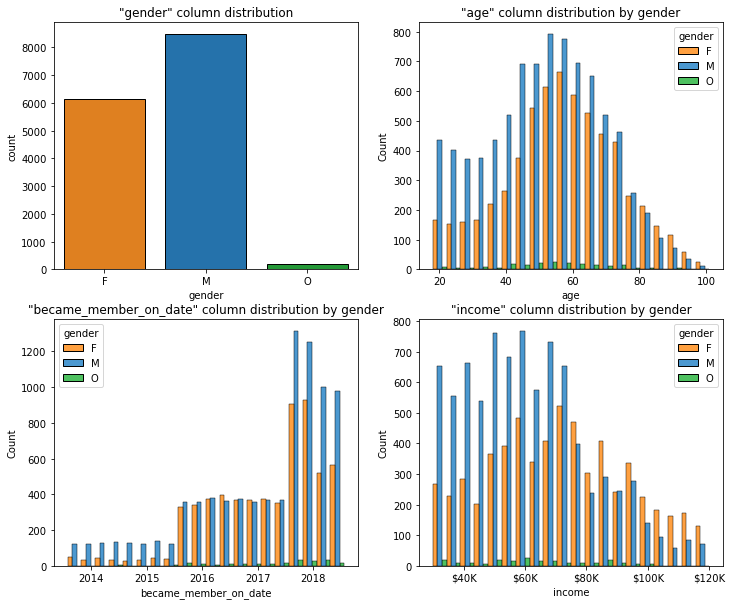

In [15]:
fig, axs = plt.subplots(2, 2, figsize = [12, 10]);

sns.countplot(x = 'gender', data = profile, edgecolor = "black", ax = axs[0, 0], palette = ['#FF8000', '#0F76C1', '#12AC2B']);
axs[0, 0].set_title('"gender" column distribution')

sns.histplot(data=profile, x='age', bins = 20, hue = 'gender', multiple = 'dodge', ax = axs[0, 1], palette = ['#FF8000', '#0F76C1', '#12AC2B']);
axs[0, 1].set_title('"age" column distribution by gender');

sns.histplot(data=profile, x='became_member_on_date', bins = 20, hue = 'gender', multiple = 'dodge', ax = axs[1, 0], palette = ['#FF8000', '#0F76C1', '#12AC2B']);
axs[1, 0].set_title('"became_member_on_date" column distribution by gender');

sns.histplot(data=profile, x='income', bins = 20, hue = 'gender', multiple = 'dodge', ax = axs[1, 1], palette = ['#FF8000', '#0F76C1', '#12AC2B']);
axs[1, 1].set_title('"income" column distribution by gender');
axs[1, 1].xaxis.set_major_formatter(currency)

Let's take a look now at the transcript table.

In [17]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [25]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [21]:
len(transcript.person.unique())

17000

It looks like we have data for all 17000 users from profile table.

In [20]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

As we can see, types of events are "offer received", "offer viewed", "transaction", "offer completed".

In [22]:
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714], dtype=int64)

In [23]:
len(transcript.time.unique())

120

Time column represents number of hours since start of the test. The data begins at time = 0.

In [87]:
transcript[transcript['event'] == 'offer completed'].head()

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


In [88]:
transcript.iloc[12658, 2]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

In the case event is "offer completed", there are two values in the dictionary. First one is offer_id, and second one is the reward that user received for completing the offer.

Now we need to break that dictionary into its elements, and put them in separate columns.

In [150]:
transcript_new = transcript.join(pd.DataFrame(transcript['value'].to_dict()).T)

In [151]:
transcript_new.head(2)

,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN


In [152]:
transcript_new[transcript_new['event'] == 'offer completed'].head(2)

,person,event,value,time,offer id,amount,offer_id,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2


It looks like if event is "offer completed", then offer id entry in the dictionary in 'value' column is written using underscore, and in all other cases it is written using just blank space.
We need to combine those two columns created from dictionary in 'value' column into one ('offer id' and 'offer_id'), since they contain the same information.

In [153]:
transcript_new['offer_id_2'] = np.where(transcript_new['offer_id'].isnull(), transcript_new['offer id'], transcript_new['offer_id'])

In [154]:
transcript_new.head()

,person,event,value,time,offer id,amount,offer_id,reward,offer_id_2
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [155]:
transcript_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   person      306534 non-null  object
 1   event       306534 non-null  object
 2   value       306534 non-null  object
 3   time        306534 non-null  int64 
 4   offer id    134002 non-null  object
 5   amount      138953 non-null  object
 6   offer_id    33579 non-null   object
 7   reward      33579 non-null   object
 8   offer_id_2  167581 non-null  object
dtypes: int64(1), object(8)
memory usage: 21.0+ MB


We don't need 'offer id' and 'offer_id' columns anymore, so we can remove them for clarity. We don't need value column either. Let's also rename some columns.

In [156]:
transcript_new = transcript_new.drop(['value', 'offer id', 'offer_id'], axis = 1)
transcript_new = transcript_new.rename(columns = {'time': 'hours_since_start', 'offer_id_2': 'offer_id', 'amount': 'amount_spent', 'reward': 'reward_received'})
transcript_new

,person,event,hours_since_start,amount_spent,reward_received,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,NaN


In [157]:
transcript_new = transcript_new[['person', 'event', 'offer_id', 'amount_spent', 'reward_received', 'hours_since_start']]

In [158]:
assert (sum(~transcript_new['amount_spent'].isnull()) + sum(~transcript_new['offer_id'].isnull())) == (transcript_new.shape[0]), "'amount' and 'offer_id' columns should complement each other and together cover all rows of data!"
assert (sum(~transcript_new['reward_received'].isnull()) == sum(transcript_new['event'] == 'offer completed')), "If event is 'offer completed', reward column should be populated!"
print ("Table looks consistent!")

Table looks consistent!


In [159]:
transcript_new[transcript_new['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,offer_id,amount_spent,reward_received,hours_since_start
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,NaN,19.89,NaN,132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,NaN,17.78,NaN,144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,NaN,19.67,NaN,222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,NaN,29.72,NaN,240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,NaN,23.93,NaN,378


In order to be able to say something about a certain user and how they respond to offers, we need to add offer info that we have in portfolio table.

In [160]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [161]:
transcript_new = pd.merge(transcript_new, portfolio, how = 'left', left_on = 'offer_id', right_on = 'id').drop('id', axis='columns')

In [162]:
transcript_new = transcript_new.rename(columns = {'difficulty': 'min_req_spending', 'duration': 'offer_duration_days'})

In [163]:
transcript_new[transcript_new['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,offer_id,amount_spent,reward_received,hours_since_start,reward,channels,min_req_spending,offer_duration_days,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,5.0,"[web, email, mobile]",5.0,7.0,bogo
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,6,5.0,"[web, email, mobile]",5.0,7.0,bogo
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,NaN,19.89,NaN,132,NaN,NaN,NaN,NaN,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,132,5.0,"[web, email, mobile]",5.0,7.0,bogo
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,NaN,17.78,NaN,144,NaN,NaN,NaN,NaN,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,168,0.0,"[email, mobile, social]",0.0,3.0,informational
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,216,0.0,"[email, mobile, social]",0.0,3.0,informational
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,NaN,19.67,NaN,222,NaN,NaN,NaN,NaN,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,NaN,29.72,NaN,240,NaN,NaN,NaN,NaN,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,NaN,23.93,NaN,378,NaN,NaN,NaN,NaN,NaN
